Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Automatic mixed precision training and evaluation

This tutorial shows how to apply the automatic mixed precision (AMP) feature of PyTorch to training and validation programs.  
It's modified from the Spleen 3D segmentation tutorial notebook, and compares the training speed and memory usage with/without AMP.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/acceleration/automatic_mixed_precision.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [ ]:
import glob
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    CropForegroundd,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.utils import get_torch_version_tuple, set_determinism

print_config()

if get_torch_version_tuple() < (1, 6):
    raise RuntimeError("AMP feature only exists in PyTorch version greater than v1.6.")

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [ ]:
train_images = sorted(glob.glob(os.path.join(data_root, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_root, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation

In [ ]:
def transformations():
    train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(
                keys=["image", "label"],
                pixdim=(1.5, 1.5, 2.0),
                mode=("bilinear", "nearest"),
            ),
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-57,
                a_max=164,
                b_min=0.0,
                b_max=1.0,
                clip=True,
            ),
            CropForegroundd(keys=["image", "label"], source_key="image"),
            # pre-compute foreground and background indexes
            # and cache them to accelerate training
            FgBgToIndicesd(
                keys="label",
                fg_postfix="_fg",
                bg_postfix="_bg",
                image_key="image",
            ),
            # randomly crop out patch samples from
            # big image based on pos / neg ratio
            # the image centers of negative samples must be in valid image area
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(128, 128, 96),
                pos=1,
                neg=1,
                num_samples=4,
                fg_indices_key="label_fg",
                bg_indices_key="label_bg",
            ),
        ]
    )
    val_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(
                keys=["image", "label"],
                pixdim=(1.5, 1.5, 2.0),
                mode=("bilinear", "nearest"),
            ),
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-57,
                a_max=164,
                b_min=0.0,
                b_max=1.0,
                clip=True,
            ),
            CropForegroundd(keys=["image", "label"], source_key="image"),
        ]
    )
    return train_transforms, val_transforms

## Define a typical PyTorch training process
Usage of PyTorch AMP module refers to: https://pytorch.org/docs/stable/notes/amp_examples.html.

In [ ]:
def train_process(amp=False):
    train_trans, val_trans = transformations()
    train_ds = CacheDataset(data=train_files, transform=train_trans, cache_rate=1.0, num_workers=8)
    val_ds = CacheDataset(data=val_files, transform=val_trans, cache_rate=1.0, num_workers=5)

    # use batch_size=2 to load images and use RandCropByPosNegLabeld
    # to generate 2 x 4 images for network training
    train_loader = DataLoader(
        train_ds,
        batch_size=2,
        shuffle=True,
        num_workers=1,
    )
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=1)
    device = torch.device("cuda:0")
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    scaler = torch.cuda.amp.GradScaler() if amp else None

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])

    dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

    max_epochs = 300
    val_interval = 1  # do validation for every epoch
    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()
    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            epoch_loss += loss.item()
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size},"
                f" train_loss: {loss.item():.4f}"
                f" step time: {(time.time() - step_start):.4f}"
            )
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (160, 160, 128)
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    else:
                        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    dice_metric(y_pred=val_outputs, y=val_labels)

                metric = dice_metric.aggregate().item()
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_metrics_epochs_and_time[0].append(best_metric)
                    best_metrics_epochs_and_time[1].append(best_metric_epoch)
                    best_metrics_epochs_and_time[2].append(time.time() - total_start)
                    torch.save(model.state_dict(), "best_metric_model.pth")
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current"
                    f" mean dice: {metric:.4f}"
                    f" best mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
        print(f"time consuming of epoch {epoch + 1}" f" is: {(time.time() - epoch_start):.4f}")
        epoch_times.append(time.time() - epoch_start)
    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {(time.time() - total_start):.4f}"
    )
    return (
        max_epochs,
        epoch_loss_values,
        metric_values,
        epoch_times,
        best_metrics_epochs_and_time,
    )

## Enable deterministic and train with AMP

In [ ]:
set_determinism(seed=0)
amp_start = time.time()
(
    max_epochs,
    amp_epoch_loss_values,
    amp_metric_values,
    amp_epoch_times,
    amp_best,
) = train_process(amp=True)
amp_total_time = time.time() - amp_start
print(f"total training time of {max_epochs} " f"epochs with AMP: {amp_total_time:.4f}")

## Check the memory usage during training with AMP

In [9]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_summary(0, abbreviated=True))

NVIDIA A100 80GB PCIe
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |    1829 MB |   47383 GB |   47383 GB |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |    1829 MB |   47383 GB |   47383 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    2366 MB |    2366 MB |    2366 MB |       0 B  |
|-----------------------------------------

## Enable deterministic and train without AMP
In order to correctly measure the memory usage, please restart the notebook and skip above AMP training.

In [ ]:
set_determinism(seed=0)
start = time.time()
(
    max_epochs,
    epoch_loss_values,
    metric_values,
    epoch_times,
    best,
) = train_process(amp=False)
total_time = time.time() - start
print(f"total training time of {max_epochs} epochs without AMP: {total_time:.4f}")

## Check the memory usage during training without AMP

In [11]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_summary(0, abbreviated=True))

NVIDIA A100 80GB PCIe
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |    2892 MB |  130153 GB |  130153 GB |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |    2892 MB |  130153 GB |  130153 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    3732 MB |    3732 MB |    3732 MB |       0 B  |
|-----------------------------------------

## Plot training loss and validation metrics

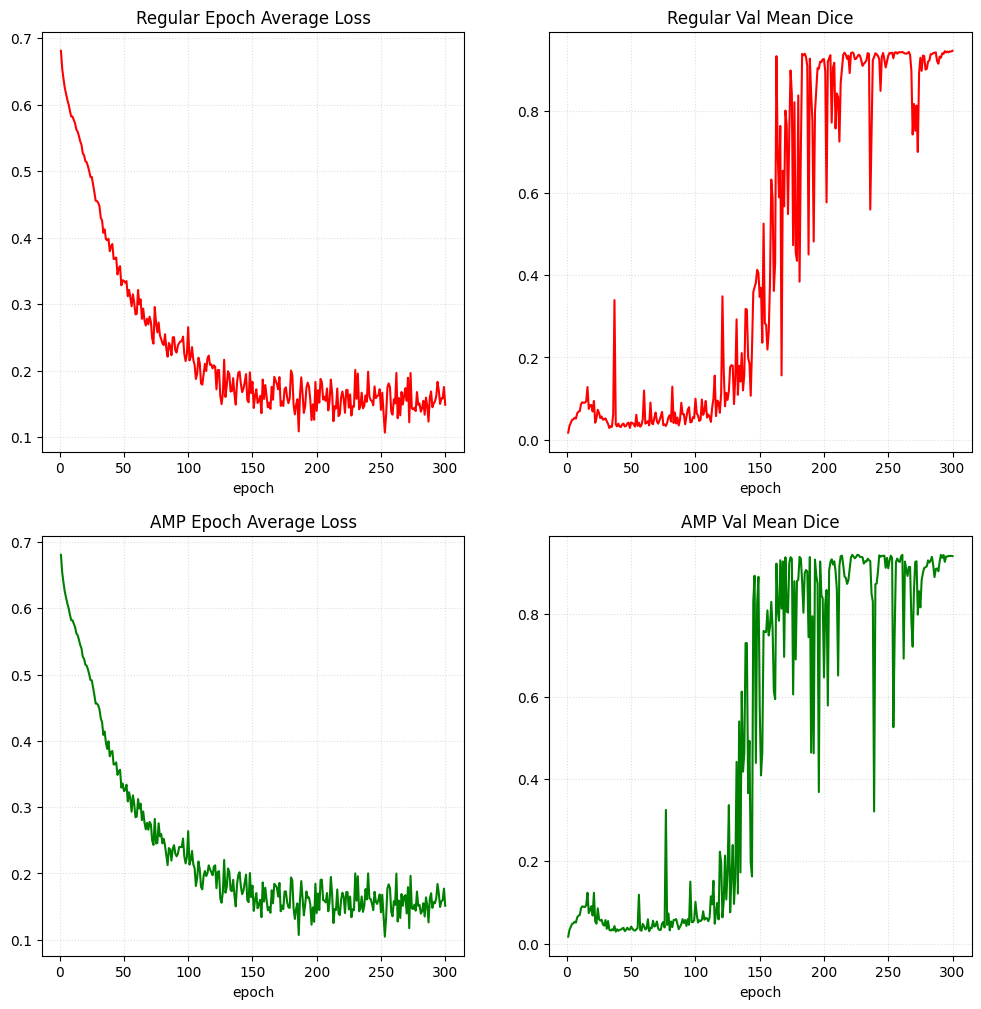

In [12]:
plt.figure("train", (12, 12))
plt.subplot(2, 2, 1)
plt.title("Regular Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(2, 2, 2)
plt.title("Regular Val Mean Dice")
x = [i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(2, 2, 3)
plt.title("AMP Epoch Average Loss")
x = [i + 1 for i in range(len(amp_epoch_loss_values))]
y = amp_epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")

plt.subplot(2, 2, 4)
plt.title("AMP Val Mean Dice")
x = [i + 1 for i in range(len(amp_metric_values))]
y = amp_metric_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")
plt.show()

## Plot total time and every epoch time

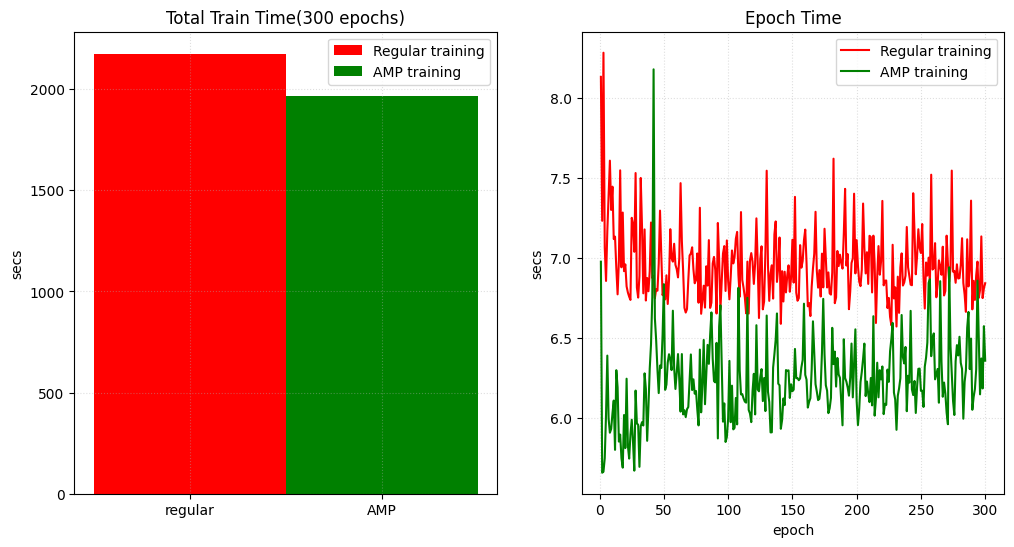

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Total Train Time(300 epochs)")
plt.bar("regular", total_time, 1, label="Regular training", color="red")
plt.bar("AMP", amp_total_time, 1, label="AMP training", color="green")
plt.ylabel("secs")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Epoch Time")
x = [i + 1 for i in range(len(epoch_times))]
plt.xlabel("epoch")
plt.ylabel("secs")
plt.plot(x, epoch_times, label="Regular training", color="red")
plt.plot(x, amp_epoch_times, label="AMP training", color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")
plt.show()

## Plot total time to achieve metrics

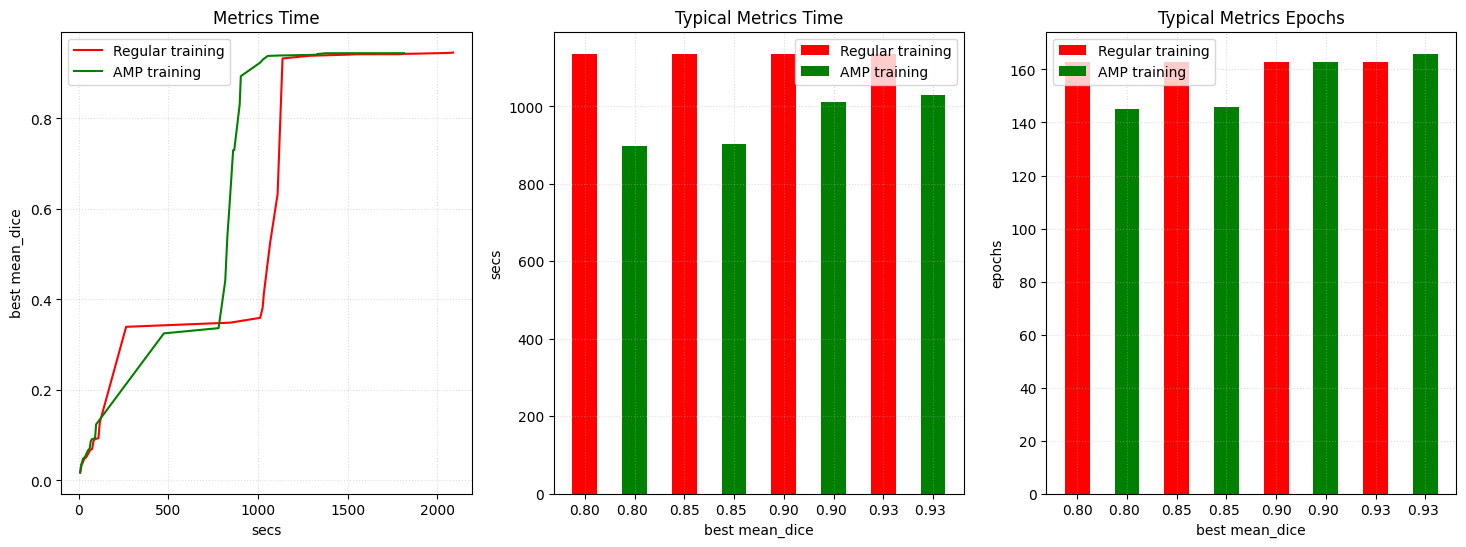

In [14]:
def get_best_metric_time(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if v > threshold:
            return best_values[2][i]
    return -1


def get_best_metric_epochs(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if v > threshold:
            return best_values[1][i]
    return -1


plt.set_loglevel("WARNING")

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Metrics Time")
plt.xlabel("secs")
plt.ylabel("best mean_dice")
plt.plot(best[2], best[0], label="Regular training", color="red")
plt.plot(amp_best[2], amp_best[0], label="AMP training", color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 3, 2)
plt.title("Typical Metrics Time")
plt.xlabel("best mean_dice")
plt.ylabel("secs")
plt.bar(
    "0.80",
    get_best_metric_time(0.8, best),
    0.5,
    label="Regular training",
    color="red",
)
plt.bar(
    "0.80 ",
    get_best_metric_time(0.8, amp_best),
    0.5,
    label="AMP training",
    color="green",
)
plt.bar("0.85", get_best_metric_time(0.85, best), 0.5, color="red")
plt.bar("0.85 ", get_best_metric_time(0.85, amp_best), 0.5, color="green")
plt.bar("0.90", get_best_metric_time(0.9, best), 0.5, color="red")
plt.bar("0.90 ", get_best_metric_time(0.9, amp_best), 0.5, color="green")
plt.bar("0.93", get_best_metric_time(0.93, best), 0.5, color="red")
plt.bar("0.93 ", get_best_metric_time(0.93, amp_best), 0.5, color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 3, 3)
plt.title("Typical Metrics Epochs")
plt.xlabel("best mean_dice")
plt.ylabel("epochs")
plt.bar(
    "0.80",
    get_best_metric_epochs(0.8, best),
    0.5,
    label="Regular training",
    color="red",
)
plt.bar(
    "0.80 ",
    get_best_metric_epochs(0.8, amp_best),
    0.5,
    label="AMP training",
    color="green",
)
plt.bar("0.85", get_best_metric_epochs(0.85, best), 0.5, color="red")
plt.bar("0.85 ", get_best_metric_epochs(0.85, amp_best), 0.5, color="green")
plt.bar("0.90", get_best_metric_epochs(0.9, best), 0.5, color="red")
plt.bar("0.90 ", get_best_metric_epochs(0.9, amp_best), 0.5, color="green")
plt.bar("0.93", get_best_metric_epochs(0.93, best), 0.5, color="red")
plt.bar("0.93 ", get_best_metric_epochs(0.93, amp_best), 0.5, color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)